In [1]:
#! pip install -q tensorflow-model-optimization
#! pip install tensorflow-addons

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from LTH_helper import prune_and_initilize, is_pruned, test_model_sparsity

https://arxiv.org/abs/1803.03635

https://www.youtube.com/watch?v=0VH1Lim8gL8&feature=youtu.be&t=2760

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
import os
import random as rn
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import tensorflow_model_optimization as tfmot
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist, mnist

In [5]:
def set_random_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed)
    rn.seed(seed)
    tf.random.set_seed(seed)
    # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    # K.set_session(sess)

# Cargo datos

In [6]:
my_dataset = fashion_mnist
(train_images, train_labels), (test_images, test_labels) = my_dataset.load_data()
X = train_images.reshape(-1, 784)/255
y = train_labels.reshape(-1, 1)
X_test = test_images.reshape(-1, 784)/255
y_test = test_labels.reshape(-1, 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# Red neuronal básica

In [51]:
def compile_model(model, lr=0.001):
    optim = optimizers.Adam(lr=lr)
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer=optim, metrics=['accuracy'])
    
def get_model(initial_weights=None, compile_model_flag=True, lr=0.001):
    reduce = 2
    input_dim=784
    output_size = 10
    # Creo el modelo
    model = Sequential()
    model.add(Dense(784*2//reduce, activation='linear', name='hidden_1', kernel_initializer=initializers.glorot_uniform(),
                    input_dim=input_dim))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(784//reduce, activation='linear', name='hidden_2', kernel_initializer=initializers.glorot_uniform(),
                   ))
    #model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dense(output_size, name='Salida', kernel_initializer=initializers.glorot_uniform(),
                   ))
    model.add(Activation('softmax'))
    if compile_model_flag:
        compile_model(model, lr=lr)
    if initial_weights is not None:
        model.save_weights(initial_weights)
    return model
model = get_model()
# model.save_weights('random-init.hdf5')
model.summary()

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_1 (Dense)             (None, 784)               615440    
_________________________________________________________________
activation_72 (Activation)   (None, 784)               0         
_________________________________________________________________
hidden_2 (Dense)             (None, 392)               307720    
_________________________________________________________________
activation_73 (Activation)   (None, 392)               0         
_________________________________________________________________
Salida (Dense)               (None, 10)                3930      
_________________________________________________________________
activation_74 (Activation)   (None, 10)                0         
Total params: 927,090
Trainable params: 927,090
Non-trainable params: 0
_______________________________________________

![LTH_alg.png](LTH_alg.png)

# Step 1 and 2. Initialize and Train network

In [52]:
def get_callbacks(filename):
    return [
        # ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=np.sqrt(0.1), patience=10, verbose=1, min_lr=1e-4),
        ModelCheckpoint(filepath=filename,  verbose=0, save_best_only=True, monitor='val_accuracy', mode='max')
    ]

In [53]:
def get_prunned_callbacks(model, filename):
    if is_pruned(model):
        return get_callbacks(filename) + [tfmot.sparsity.keras.UpdatePruningStep()]
    else:
        return get_callbacks(filename)

In [54]:
def train_model(model, callbacks, batch_size = 512, epochs = 10):
    history = model.fit(X_train, 
               y_train,
               epochs=epochs, batch_size=batch_size, 
               validation_data = (X_val, y_val),
               verbose=0, 
               callbacks=callbacks
              )
    return model, history

initial_weights = 'mlp.mnist.initial_weights.hdf5'
best_weights = 'mlp.mnist.first_train.hdf5'

In [55]:
# model = get_model(initial_weights)
# model = prune_and_initilize(model, 0.5, initial_weights)
# test_model_sparsity(model)
# model = prune_and_initilize(model, 0.35, initial_weights)
# test_model_sparsity(model)

In [56]:
model = get_model(initial_weights)
pms = [1, 0.5, 0.353, 0.210] #, 0.096]
histories = []
for pm in pms:
    if pm<1:
        model = prune_and_initilize(model, pm, initial_weights)
        compile_model(model)
    test_model_sparsity(model)
    
    print(model.evaluate(X_test, y_test, verbose=0))
    model, history = train_model(model, get_prunned_callbacks(model, best_weights))
    histories.append(history)
    model.load_weights(best_weights)
    print(model.evaluate(X_test, y_test, verbose=0))
    print()

hidden_1: 0.0 - no mask
hidden_2: 0.0 - no mask
Salida: 0.0 - no mask
[2.440572738647461, 0.10589999705553055]
[0.33213046193122864, 0.8812000155448914]

prune_low_magnitude_hidden_1: 0.5, 1.0
prune_low_magnitude_hidden_2: 0.5, 1.0
prune_low_magnitude_Salida: 0.5, 1.0
[0.6603261232376099, 0.7973999977111816]
[0.32144299149513245, 0.886900007724762]

prune_low_magnitude_hidden_1: 0.6469992971678468, 1.0
prune_low_magnitude_hidden_2: 0.6469992971678468, 1.0
prune_low_magnitude_Salida: 0.6469387755102041, 1.0
[0.912895143032074, 0.7202000021934509]
[0.316006064414978, 0.8881999850273132]

prune_low_magnitude_hidden_1: 0.7899996095376927, 1.0
prune_low_magnitude_hidden_2: 0.7899996095376927, 1.0
prune_low_magnitude_Salida: 0.7900510204081632, 1.0
[0.9967957735061646, 0.7656999826431274]
[0.3140208125114441, 0.886900007724762]



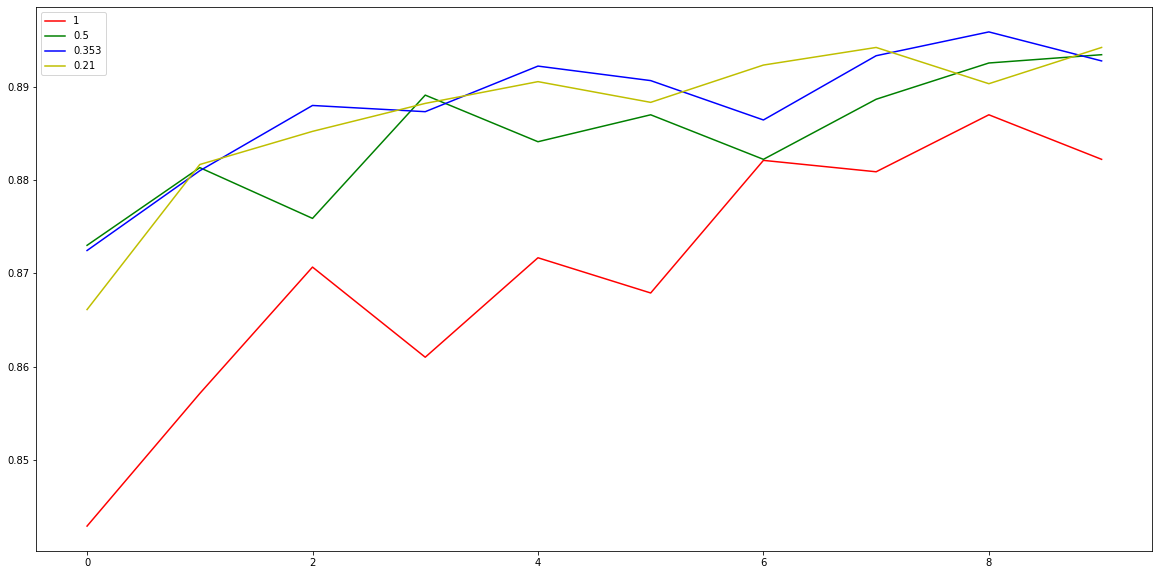

In [60]:
c = ['r', 'g', 'b', 'y']
plt.figure(figsize=(20,10))
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], c=c[i], label=f'{pms[i]}')
plt.legend()

In [118]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning

In [119]:
last_model = strip_pruning(model)
compile_model(last_model)
last_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 824us/step - loss: 0.3041 - accuracy: 0.8941


[0.3041163980960846, 0.89410001039505]

In [120]:
(last_model.get_weights()[2] == 0).sum()/(last_model.get_weights()[2] != 1).sum()

0.7899996095376927

In [121]:
weights = last_model.get_weights()
for i, w in enumerate(weights):
    print(w.shape)

(784, 784)
(784,)
(784, 392)
(392,)
(392, 10)
(10,)


In [122]:
neurons_to_kill = np.where((weights[4]!=0).sum(axis=1) == 0)
len(neurons_to_kill[0])

47

In [123]:
weights[2][:, neurons_to_kill] = 0

In [124]:
last_model.set_weights(weights)
last_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 814us/step - loss: 0.3041 - accuracy: 0.8941


[0.3041163980960846, 0.89410001039505]

In [125]:
(last_model.get_weights()[2] == 0).sum()/(last_model.get_weights()[2] != 1).sum()

0.8082960224906289